In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython.display import clear_output

tf.keras.mixed_precision.set_global_policy('float32')


In [ ]:
def load_image_pair(file_path):
    s1_path = tf.strings.regex_replace(file_path, r'/s[12]$', '/s1')
    s2_path = tf.strings.regex_replace(file_path, r'/s[12]$', '/s2')

    mono = load_and_preprocess_image(s1_path, grayscale=True)
    color = load_and_preprocess_image(s2_path, grayscale=False)

    return mono, color

def load_and_preprocess_image(file_path, grayscale=False):
    image = tf.io.read_file(file_path)
    if grayscale:
        image = tf.image.decode_png(image, channels=1)
    else:
        image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def create_dataset(base_path, batch_size, max_samples_per_category=200):
    categories = ['agri', 'barrenland', 'grassland', 'urban']
    all_paths = []

    for category in categories:
        category_path = os.path.join(base_path, category)
        s1_paths = tf.data.Dataset.list_files(os.path.join(category_path, 's1', '*'), shuffle=True)
        s1_paths = s1_paths.take(max_samples_per_category)
        all_paths.append(s1_paths)

    all_paths = tf.data.Dataset.from_tensor_slices(all_paths)
    all_paths = all_paths.flat_map(lambda x: x)

    dataset = all_paths.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=4000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

def attention_gate(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, 1, use_bias=False)(x)
    phi_g = layers.Conv2D(inter_channel, 1, use_bias=False)(g)

    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, 1, use_bias=False)(f)

    rate = layers.Activation('sigmoid')(psi_f)
    att_x = layers.multiply([x, rate])

    return att_x

def attention_unet_generator(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(e1)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(e2)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    e3 = layers.Conv2D(256, 3, activation='relu', padding='same')(e3)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    # Bridge
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)

    # Decoder
    d3 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(b)
    d3 = attention_gate(e3, d3, 128)
    d3 = layers.concatenate([d3, e3])
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(d3)
    d3 = layers.Conv2D(256, 3, activation='relu', padding='same')(d3)

    d2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(d3)
    d2 = attention_gate(e2, d2, 64)
    d2 = layers.concatenate([d2, e2])
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(d2)
    d2 = layers.Conv2D(128, 3, activation='relu', padding='same')(d2)

    d1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(d2)
    d1 = attention_gate(e1, d1, 32)
    d1 = layers.concatenate([d1, e1])
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(d1)
    d1 = layers.Conv2D(64, 3, activation='relu', padding='same')(d1)

    outputs = layers.Conv2D(3, 1, activation='tanh')(d1)

    return models.Model(inputs=inputs, outputs=outputs)

def conditional_patchgan_discriminator(input_shape=(256, 256, 3), condition_shape=(256, 256, 1)):
    input_img = layers.Input(shape=input_shape)
    input_condition = layers.Input(shape=condition_shape)

    x = layers.concatenate([input_img, input_condition])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return models.Model(inputs=[input_img, input_condition], outputs=x)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

@tf.function
def train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([target, input_image], training=True)
        disc_generated_output = discriminator([gen_output, input_image], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def fit(train_ds, test_ds, steps_per_epoch, epochs, generator, discriminator):
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    example_input, example_target = next(iter(test_ds.take(1)))

    for epoch in range(epochs):
        start = time.time()

        for step, (input_image, target) in enumerate(train_ds):
            if step >= steps_per_epoch:
                break

            gen_total_loss, disc_loss = train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer)

            if (step + 1) % 10 == 0:
                print('.', end='', flush=True)

            if (step + 1) % 100 == 0:
                clear_output(wait=True)
                generate_images(generator, example_input, example_target)
                print(f"Epoch {epoch+1}/{epochs}, Step {step+1}/{steps_per_epoch}")
                print(f"Generator Loss: {gen_total_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")

        print(f"\nTime taken for epoch {epoch+1}: {time.time() - start:.2f} sec")

        if (epoch + 1) % 5 == 0:
            generator_save_path = f'../models/generator_epoch_{epoch+1}.keras'
            discriminator_save_path = f'../models/discriminator_epoch_{epoch+1}.keras'

            generator.save(generator_save_path)
            discriminator.save(discriminator_save_path)

            print(f"Models saved at epoch {epoch+1}: \nGenerator: {generator_save_path} \nDiscriminator: {discriminator_save_path}")
def main():
    BASE_PATH = '../data/v_2/'
    BATCH_SIZE = 8
    EPOCHS = 20
    MAX_SAMPLES_PER_CATEGORY = 200

    full_dataset = create_dataset(BASE_PATH, BATCH_SIZE, MAX_SAMPLES_PER_CATEGORY)

    dataset_size = sum(1 for _ in full_dataset)

    train_size = int(0.8 * dataset_size)
    steps_per_epoch = train_size // BATCH_SIZE

    train_dataset = full_dataset.take(train_size)
    test_dataset = full_dataset.skip(train_size)

    train_dataset = train_dataset.repeat()
    test_dataset = test_dataset.repeat()

    generator = attention_unet_generator()
    discriminator = conditional_patchgan_discriminator()

    fit(train_dataset, test_dataset, steps_per_epoch, EPOCHS, generator, discriminator)

if __name__ == "__main__":
    main()

c:\Users\Naman\Desktop\Repos\sar\model\env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


.
Time taken for epoch 1: 98.15 sec
.
Time taken for epoch 2: 92.22 sec
.
Time taken for epoch 3: 92.44 sec
.
Time taken for epoch 4: 90.28 sec
.
Time taken for epoch 5: 89.58 sec
Models saved at epoch 5: 
Generator: ../models/generator_epoch_5.keras 
Discriminator: ../models/discriminator_epoch_5.keras
.
Time taken for epoch 6: 89.23 sec
.
Time taken for epoch 7: 92.44 sec
.
Time taken for epoch 8: 92.44 sec
.
Time taken for epoch 9: 91.65 sec
.
Time taken for epoch 10: 91.71 sec
Models saved at epoch 10: 
Generator: ../models/generator_epoch_10.keras 
Discriminator: ../models/discriminator_epoch_10.keras
.
Time taken for epoch 11: 91.21 sec
.
Time taken for epoch 12: 91.17 sec
.
Time taken for epoch 13: 92.14 sec
.
Time taken for epoch 14: 90.15 sec
.
Time taken for epoch 15: 93.46 sec
Models saved at epoch 15: 
Generator: ../models/generator_epoch_15.keras 
Discriminator: ../models/discriminator_epoch_15.keras
.
Time taken for epoch 16: 96.32 sec
.
Time taken for epoch 17: 99.22 sec

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

generator = load_model('../models/generator_epoch_20.keras')

In [7]:
def preprocess_image(image_path):
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray_img is None:
        raise ValueError("Image not found or unable to load.")
    gray_img = gray_img / 255.0
    gray_img_resized = cv2.resize(gray_img, (256, 256))
    gray_img_resized = gray_img_resized.reshape(1, 256, 256, 1)
    return gray_img_resized


In [8]:
def postprocess_and_display(output, original_image_path):
    output = np.clip(output[0], 0, 1)
    output = (output * 255).astype(np.uint8)

    if output.shape[-1] != 3:
        raise ValueError("Output shape is not as expected. Check model output.")

    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        raise ValueError("Original image not found or unable to load.")
    original_img_resized = cv2.resize(original_img, (256, 256))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(original_img_resized, cmap='gray')
    ax[0].set_title('Original Grayscale Image')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Colorized Image')
    ax[1].axis('off')

    plt.show()


In [10]:
input_image_path = './image.png'
gray_img = preprocess_image(input_image_path)

In [11]:
output = generator.predict(gray_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


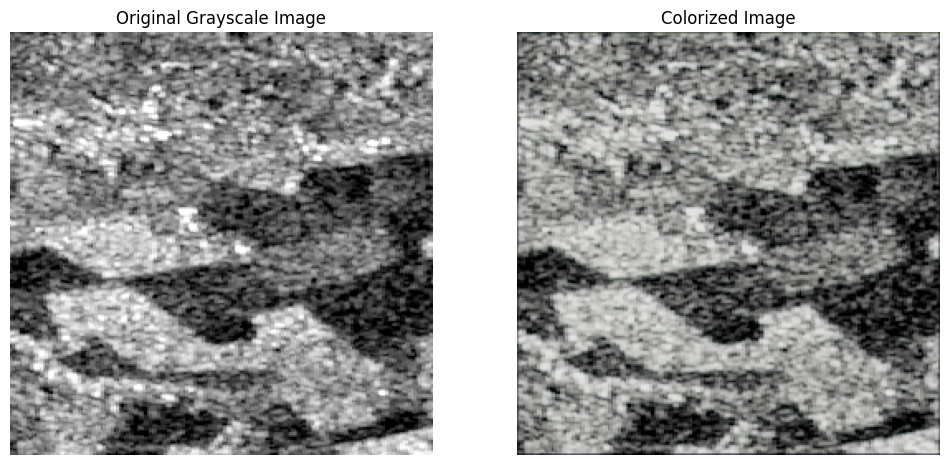

In [12]:
postprocess_and_display(output, input_image_path)